In [1]:
import os
parent_directory = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
grandparent_directory = os.path.abspath(os.path.join(parent_directory, os.pardir))
os.sys.path.append(grandparent_directory)

import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import plotly.graph_objects as go

from tools.data_formatting import get_smoothed_moving_all_data, get_common_indexes_n_recordings, smooth_tuning_curves_circularly, from_local_to_global_index
from tools.data_manager import get_all_experiments_runs, get_fovs_given_animal
from tools.alignment import procrustes, canoncorr
from global_vars import order_experiments, get_colors_for_each_experiment, animals, root_dir, experiments_to_exclude

# Load the sessions

In [2]:
### Load all sessions ###

animal = 'm135'
fov = 'fov1'
sessions = get_all_experiments_runs(animal, fov)
# Remove sessions to exclude
sessions = [session for session in sessions if session not in experiments_to_exclude]
# Create a mapping of sessions and their chronological order
order_map = {value: index for index, value in enumerate(order_experiments)}
sessions = sorted(sessions, key=lambda x: order_map[x])

# Load the cells with the global index and the tuning curves
all_cells = []
all_tuning_curves = []
for (experiment, run) in sessions:
    _, _, phi, cells, tuning_curves, _ = get_smoothed_moving_all_data(animal, fov, experiment, run)
    cells = from_local_to_global_index(animal, fov, (experiment, run), cells)
    all_cells.append(cells)
    all_tuning_curves.append(tuning_curves)

# Visualise the tuning curves before alignment

Cells in common: 84


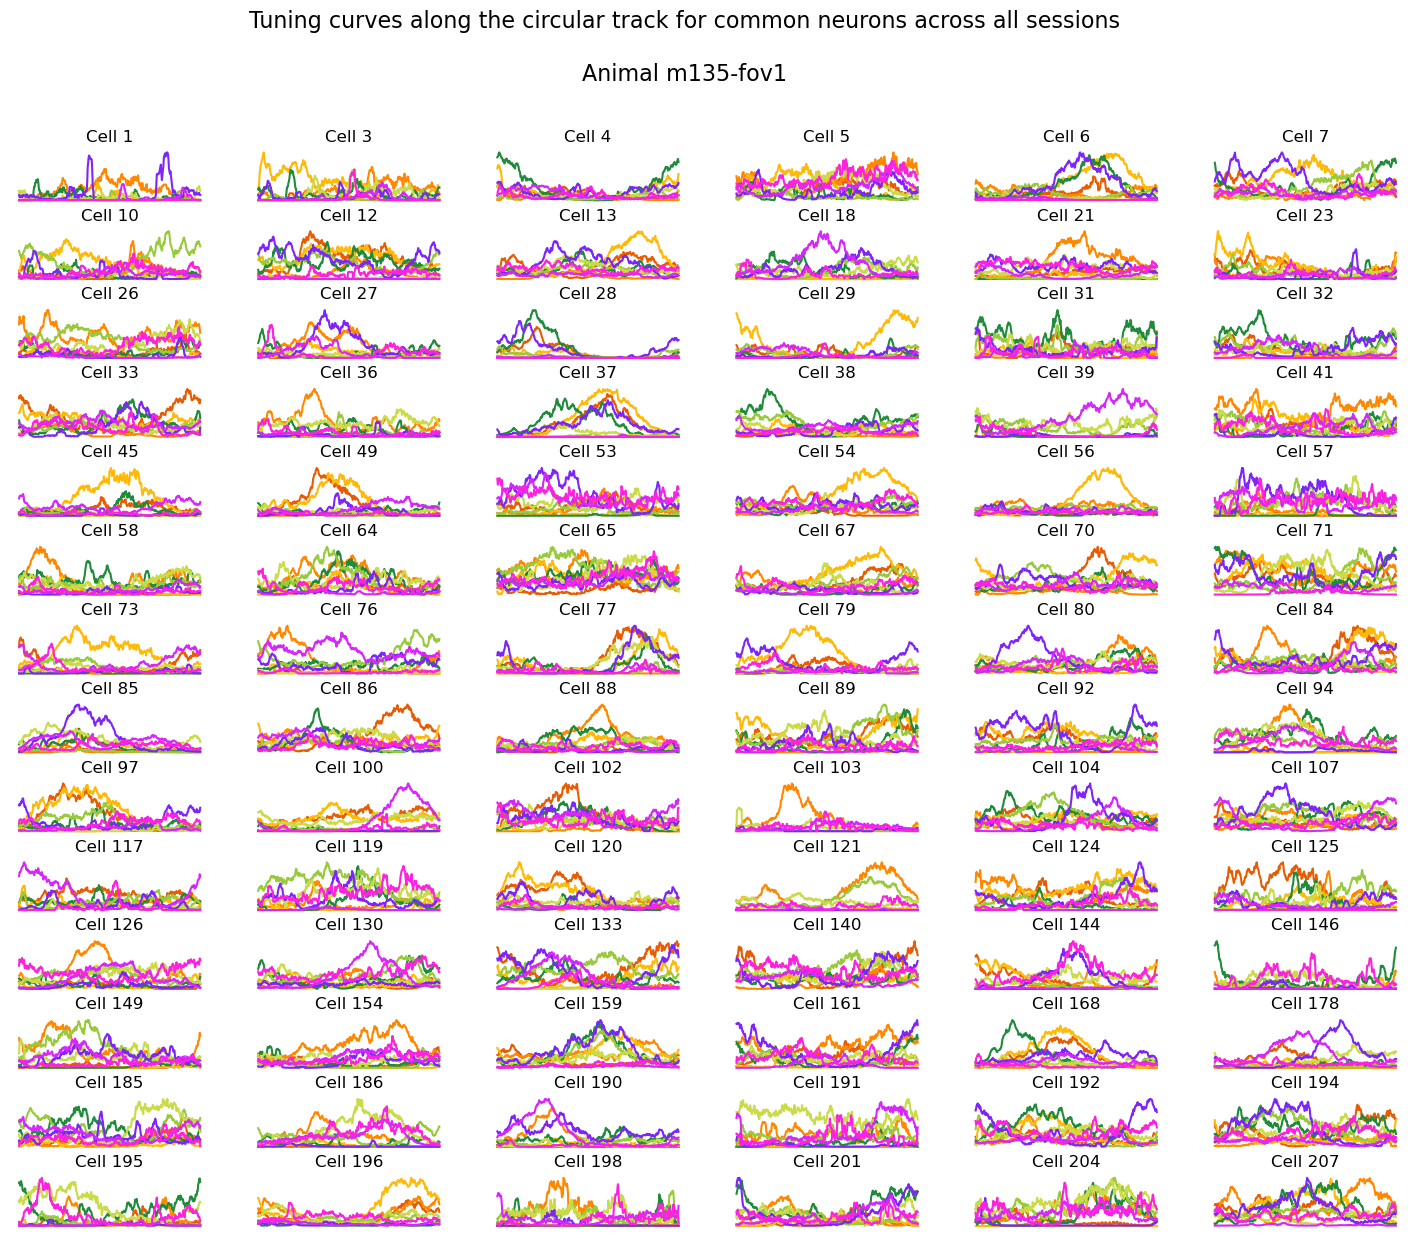

In [6]:
# Get the common cells and order all the tuning curves accordingly
sel_cells_masks, ordered_cells, common_neurons = get_common_indexes_n_recordings(all_cells)
print(f'Cells in common: {len(ordered_cells[0])}')
# Remove the cells that are not common to all recordings
sel_tuning_curves = [tuning_curves[:, mask] for tuning_curves, mask in zip(all_tuning_curves, sel_cells_masks)]
# Order all the cells such that indexes correspond to the same cell across all recordings
sel_tuning_curves = [tuning_curves[:, order] for tuning_curves, order in zip(sel_tuning_curves, ordered_cells)]
# Smooth the tuning curves
smoothed_tuning_curves = [smooth_tuning_curves_circularly(tuning_curves, 10) for tuning_curves in sel_tuning_curves]

# Plot tuning curves of common neurons
n_cols = 6
colors = get_colors_for_each_experiment(sessions)
fig = plt.figure(figsize=(3*n_cols, 1*(len(common_neurons)//n_cols)))
grid = plt.GridSpec(nrows=np.ceil(len(common_neurons)/n_cols).astype(int), ncols=n_cols, figure=fig, wspace=0.2, hspace=0.5)
for n in range(len(common_neurons)):
    row = n // n_cols
    col = n % n_cols
    ax = fig.add_subplot(grid[row, col])
    for s, session in enumerate(sessions):
        ax.plot(np.arange(tuning_curves.shape[0]), smoothed_tuning_curves[s][:, n], color=colors[s])
    ax.set_title(f'Cell {common_neurons[n]}')
    ax.set_axis_off()

fig.suptitle(f'Tuning curves along the circular track for common neurons across all sessions\n\nAnimal {animal}-{fov}', fontsize=16)
plt.show()
    